<a href="https://colab.research.google.com/github/oonid/growth-hacking-with-nlp-sentiment-analysis/blob/master/create_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluate Amazon Video Games Review Dataset

In [1]:
# ndjson to handle newline delimited json
!pip install ndjson
# update imbalanced-learn lib on colab
!pip install --upgrade imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.6.2)


In [2]:
# all imports and related

%matplotlib inline

import pandas as pd
import numpy as np
import altair as alt
import ndjson

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler


Using TensorFlow backend.


In [3]:
# get dataset, extract from gzip (overwrite), and preview data on file
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
!yes y | gunzip Video_Games_5.json.gz
!head Video_Games_5.json

--2020-05-29 14:17:40--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/octet-stream]
Saving to: ‘Video_Games_5.json.gz’

Video_Games_5.json. 100%[===================>] 146.91M  43.6MB/s    in 3.7s    

2020-05-29 14:17:44 (39.2 MB/s) - ‘Video_Games_5.json.gz’ saved [154050105/154050105]

{"overall": 5.0, "verified": true, "reviewTime": "10 17, 2015", "reviewerID": "A1HP7NVNPFMA4N", "asin": "0700026657", "reviewerName": "Ambrosia075", "reviewText": "This game is a bit hard to get the hang of, but when you do it's great.", "summary": "but when you do it's great.", "unixReviewTime": 1445040000}
{"overall": 4.0, "verified": false, "reviewTime": "07 27, 2015", "reviewerID": "A1JGAP0185YJI6", "asin": "0700026657", "reviewerName"

In [4]:
# load from file-like objects
with open('Video_Games_5.json') as f:
    vg5 = ndjson.load(f)

print('data loaded as {} with len {}'.format(type(vg5), len(vg5)))
# sample out 2 data
vg5[:2]

data loaded as <class 'list'> with len 497577


[{'asin': '0700026657',
  'overall': 5.0,
  'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.",
  'reviewTime': '10 17, 2015',
  'reviewerID': 'A1HP7NVNPFMA4N',
  'reviewerName': 'Ambrosia075',
  'summary': "but when you do it's great.",
  'unixReviewTime': 1445040000,
  'verified': True},
 {'asin': '0700026657',
  'overall': 4.0,
  'reviewText': 'I played it a while but it was alright. The steam was a bit of trouble. The more they move these game to steam the more of a hard time I have activating and playing a game. But in spite of that it was fun, I liked it. Now I am looking forward to anno 2205 I really want to play my way to the moon.',
  'reviewTime': '07 27, 2015',
  'reviewerID': 'A1JGAP0185YJI6',
  'reviewerName': 'travis',
  'summary': 'But in spite of that it was fun, I liked it',
  'unixReviewTime': 1437955200,
  'verified': False}]

In [5]:
# load list of dict as panda DataFrame
df = pd.DataFrame(vg5)
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [6]:
# describe to understand values of column overall (next as ratings)
df.describe()

,overall,unixReviewTime
count,497577.000000,4.975770e+05
mean,4.220456,1.367848e+09
std,1.185424,1.224113e+08
min,1.000000,9.398592e+08
25%,4.000000,1.316563e+09
50%,5.000000,1.410221e+09
75%,5.000000,1.452384e+09
max,5.000000,1.538438e+09


In [7]:
# create copy of DataFrame with overall as index, to prepare plotting
dfo = df.set_index('overall')
dfo.head()

,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
overall,,,,,,,,,,,
5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [8]:
# group data by column overall (currently as index) and count the variants
dfo.groupby(dfo.index).count()

,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
overall,,,,,,,,,,,
1.0,30883,30883,30883,30883,30877,30879,30876,30883,14241,18613,277
2.0,24135,24135,24135,24135,24132,24133,24130,24135,8902,14295,121
3.0,49146,49146,49146,49146,49132,49140,49144,49146,14354,28954,259
4.0,93654,93654,93654,93654,93640,93644,93645,93654,22790,53656,648
5.0,299759,299759,299759,299759,299720,299623,299673,299759,47506,173719,2329


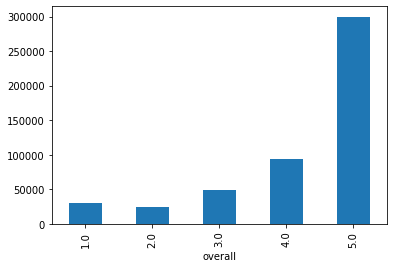

In [9]:
# plot grouped data by overall related to column reviewText (next as reviews)
dfo.groupby(dfo.index)['reviewText'].count().plot(kind='bar')

In [10]:
# dataset with only two columns (overall, reviewText) as numpy array
X = df[['overall', 'reviewText']].to_numpy()
print('dataset X shape: {} type: {}'.format(X.shape, type(X)))
# using column overall as label
y = df['overall'].to_numpy()
print('label y shape: {} type: {}'.format(y.shape, type(y)))


dataset X shape: (497577, 2) type: <class 'numpy.ndarray'>
label y shape: (497577,) type: <class 'numpy.ndarray'>


# Generating small_corpus

In [11]:
# predefined sampling strategy
sampling_strategy = {1.0: 1500, 2.0: 500, 3.0: 500, 4.0: 500, 5.0: 1500}

random_state = 42  # to get identical results with sample solution

rus = RandomUnderSampler(random_state=random_state,
                         sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)

print('initial label: {}'.format(Counter(y)))
print('result label: {}'.format(Counter(y_res)))

initial label: Counter({5.0: 299759, 4.0: 93654, 3.0: 49146, 1.0: 30883, 2.0: 24135})
result label: Counter({1.0: 1500, 5.0: 1500, 2.0: 500, 3.0: 500, 4.0: 500})


In [12]:
# convert from numpy array back to pandas DataFrame
small_corpus = pd.DataFrame({'ratings': X_res[:, 0], 'reviews': X_res[:, 1]})
# set ratings column type as int32
small_corpus['ratings'] = small_corpus['ratings'].astype('int32')
# get info of small_corpus DataFrame with total 1500+500+500+500+1500 entries
small_corpus.info()
small_corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ratings  4500 non-null   int32 
 1   reviews  4496 non-null   object
dtypes: int32(1), object(1)
memory usage: 52.9+ KB


,ratings,reviews
0,1,Recently UBISOFT had to settle a huge class-ac...
1,1,"code didn't work, got me a refund."
2,1,"these do not work at all, all i get is static ..."
3,1,well let me start by saying that when i first ...
4,1,"Dont waste your money, you will just end up us..."


In [0]:
# export small_corpus to csv (1500+500+500+500+1500), without index
small_corpus.to_csv('small_corpus.csv', index=False)

# Generating big_corpus

In [0]:
random_state = 42  # to get identical results with sample solution
np.random.seed(random_state)

# get 100.000 on random ratings (1-5) as numpy array
random_ratings = np.random.randint(low=1, high=6, size=100000)

In [16]:
# create sampling strategy by count total ratings on random_ratings (dataframe)
unique, counts = np.unique(random_ratings, return_counts=True)
sampling_strategy = {}
for k, v in zip(unique, counts):
    sampling_strategy[k] = v
print('sampling_strategy: {}'.format(sampling_strategy))

sampling_strategy: {1: 20018, 2: 20082, 3: 19732, 4: 19981, 5: 20187}


In [17]:
rus = RandomUnderSampler(random_state=random_state,
                         sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)

print('initial label: {}'.format(Counter(y)))
print('result label: {}'.format(Counter(y_res)))

initial label: Counter({5.0: 299759, 4.0: 93654, 3.0: 49146, 1.0: 30883, 2.0: 24135})
result label: Counter({5.0: 20187, 2.0: 20082, 1.0: 20018, 4.0: 19981, 3.0: 19732})


In [18]:
# convert from numpy array back to pandas DataFrame
big_corpus = pd.DataFrame({'ratings': X_res[:, 0], 'reviews': X_res[:, 1]})
# set ratings column type as int32
big_corpus['ratings'] = big_corpus['ratings'].astype('int32')
big_corpus.info()
big_corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ratings  100000 non-null  int32 
 1   reviews  99985 non-null   object
dtypes: int32(1), object(1)
memory usage: 1.1+ MB


,ratings,reviews
0,1,Recently UBISOFT had to settle a huge class-ac...
1,1,"code didn't work, got me a refund."
2,1,"these do not work at all, all i get is static ..."
3,1,well let me start by saying that when i first ...
4,1,"Dont waste your money, you will just end up us..."


In [0]:
# export big_corpus to csv (100000)
big_corpus.to_csv('big_corpus.csv')